In [8]:

import pandas as pd, numpy as np, os, joblib
from datetime import datetime
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt



In [9]:
os.makedirs("models", exist_ok=True)
os.makedirs("results", exist_ok=True)
os.makedirs("logs", exist_ok=True)

# Also ensure the log CSV exists
log_file = "logs/model_log.csv"
if not os.path.exists(log_file):
    with open(log_file, "w") as f:
        f.write("model_id,model_type,AUC,date,params,notes\n")


In [10]:

# Load and preprocess data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

X = train.drop(columns=["label"])
y = train["label"]

X, test = pd.get_dummies(X), pd.get_dummies(test)
X, test = X.align(test, join="left", axis=1, fill_value=0)

X = SimpleImputer().fit_transform(X)
test = SimpleImputer().fit_transform(test)
X = StandardScaler().fit_transform(X)
test = StandardScaler().fit_transform(test)


C:\Users\Jude Younis\AppData\Local\Temp\ipykernel_7488\2830735782.py:2: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("train.csv")
C:\Users\Jude Younis\AppData\Local\Temp\ipykernel_7488\2830735782.py:3: DtypeWarning: Columns (15,19) have mixed types. Specify dtype option on import or set low_memory=False.
  test = pd.read_csv("test.csv")


In [ ]:
# STEP 7: K-Nearest Neighbors (KNN) Model

def train_knn_model(X_scaled, y, test_scaled, test_preds, n_neighbors=5, model_name='KNN'):
    # Train final model on all data
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(X_scaled, y)

    # 5-fold cross-validation
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = []

    for train_idx, val_idx in kf.split(X_scaled, y):
        X_train_fold, X_val_fold = X_scaled[train_idx], X_scaled[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

        knn_fold = KNeighborsClassifier(n_neighbors=n_neighbors)
        knn_fold.fit(X_train_fold, y_train_fold)
        y_val_pred = knn_fold.predict_proba(X_val_fold)[:, 1]
        auc = roc_auc_score(y_val_fold, y_val_pred)
        auc_scores.append(auc)

    mean_auc = np.mean(auc_scores)
    print(f"[{model_name}] 5-fold CV AUC: {mean_auc:.4f}")

    # Store predictions on test set
    test_preds[model_name] = model.predict_proba(test_scaled)[:, 1]

    return model, mean_auc

# Call the model
knn_model, knn_auc = train_knn_model(X_scaled, y, test_scaled, test_preds)


In [11]:

def run_rf_v1():
    os.makedirs("models", exist_ok=True)
    os.makedirs("results", exist_ok=True)
    os.makedirs("logs", exist_ok=True)

    model_id = "rf_v1"
    model_type = "RandomForest"
    notes = "User baseline: 100 trees, depth=15, leaf=5"

    params = {
        "n_estimators": 100,
        "max_depth": 15,
        "min_samples_leaf": 5,
        "max_features": "sqrt",
        "bootstrap": True,
        "random_state": 42,
        "n_jobs": -1
    }

    model = RandomForestClassifier(**params)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    test_preds = np.zeros(test.shape[0])
    aucs = []

    for train_idx, val_idx in skf.split(X, y):
        model.fit(X[train_idx], y[train_idx])
        val_probs = model.predict_proba(X[val_idx])[:, 1]
        aucs.append(roc_auc_score(y[val_idx], val_probs))
        test_preds += model.predict_proba(test)[:, 1] / skf.n_splits

    mean_auc = np.mean(aucs)
    print(f"✅ AUC ({model_id}):", mean_auc)

    # Save results
    joblib.dump(model, f"models/{model_id}.pkl")
    pd.DataFrame({"Id": range(len(test_preds)), "Prediction": test_preds}).to_csv(f"results/{model_id}.csv", index=False)

    log_path = "logs/model_log.csv"
    entry = pd.DataFrame([{
        "model_id": model_id,
        "model_type": model_type,
        "AUC": mean_auc,
        "date": datetime.now().strftime("%Y-%m-%d"),
        "params": str(params),
        "notes": notes
    }])
    if os.path.exists(log_path):
        log = pd.read_csv(log_path)
        log = pd.concat([log, entry], ignore_index=True)
    else:
        log = entry
    log.to_csv(log_path, index=False)


In [12]:

def run_rf_v2():
    model_id = "rf_v2"
    model_type = "RandomForest"
    notes = "Suggested: 300 trees, depth=17, leaf=3 (more expressive)"

    params = {
        "n_estimators": 300,
        "max_depth": 17,
        "min_samples_leaf": 3,
        "max_features": "sqrt",
        "bootstrap": True,
        "random_state": 42,
        "n_jobs": -1
    }

    model = RandomForestClassifier(**params)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    test_preds = np.zeros(test.shape[0])
    aucs = []

    for train_idx, val_idx in skf.split(X, y):
        model.fit(X[train_idx], y[train_idx])
        val_probs = model.predict_proba(X[val_idx])[:, 1]
        aucs.append(roc_auc_score(y[val_idx], val_probs))
        test_preds += model.predict_proba(test)[:, 1] / skf.n_splits

    mean_auc = np.mean(aucs)
    print(f"✅ AUC ({model_id}):", mean_auc)

    joblib.dump(model, f"models/{model_id}.pkl")
    pd.DataFrame({"Id": range(len(test_preds)), "Prediction": test_preds}).to_csv(f"results/{model_id}.csv", index=False)

    log_path = "logs/model_log.csv"
    entry = pd.DataFrame([{
        "model_id": model_id,
        "model_type": model_type,
        "AUC": mean_auc,
        "date": datetime.now().strftime("%Y-%m-%d"),
        "params": str(params),
        "notes": notes
    }])
    log = pd.read_csv(log_path) if os.path.exists(log_path) else pd.DataFrame()
    pd.concat([log, entry], ignore_index=True).to_csv(log_path, index=False)

    # Plot feature importance
    importances = model.feature_importances_
    indices = np.argsort(importances)[-10:][::-1]
    plt.bar(range(10), importances[indices])
    plt.xticks(range(10), [str(i) for i in indices], rotation=45)
    plt.title("Top 10 Feature Importances (RF v2)")
    plt.tight_layout()
    plt.show()


In [13]:

def run_xgb_v1():
    model_id = "xgb_v1"
    model_type = "XGBoost"
    notes = "Basic XGBoost model: depth=6, estimators=300, learning_rate=0.1"

    params = {
        "n_estimators": 300,
        "max_depth": 6,
        "learning_rate": 0.1,
        "eval_metric": "logloss",
        "random_state": 42
    }

    model = XGBClassifier(**params)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    test_preds = np.zeros(test.shape[0])
    aucs = []

    for train_idx, val_idx in skf.split(X, y):
        model.fit(X[train_idx], y[train_idx])
        val_probs = model.predict_proba(X[val_idx])[:, 1]
        aucs.append(roc_auc_score(y[val_idx], val_probs))
        test_preds += model.predict_proba(test)[:, 1] / skf.n_splits

    mean_auc = np.mean(aucs)
    print(f"✅ AUC ({model_id}):", mean_auc)

    joblib.dump(model, f"models/{model_id}.pkl")
    pd.DataFrame({"Id": range(len(test_preds)), "Prediction": test_preds}).to_csv(f"results/{model_id}.csv", index=False)

    log_path = "logs/model_log.csv"
    entry = pd.DataFrame([{
        "model_id": model_id,
        "model_type": model_type,
        "AUC": mean_auc,
        "date": datetime.now().strftime("%Y-%m-%d"),
        "params": str(params),
        "notes": notes
    }])
    log = pd.read_csv(log_path) if os.path.exists(log_path) else pd.DataFrame()
    pd.concat([log, entry], ignore_index=True).to_csv(log_path, index=False)

    # Plot feature importance
    plot_importance(model, max_num_features=10)
    plt.title("Top 10 Feature Importances (XGB v1)")
    plt.tight_layout()
    plt.show()


In [14]:

def run_xgb_v2():
    model_id = "xgb_v2"
    model_type = "XGBoost"
    notes = "Shallower trees: depth=3, estimators=100 to check overfitting"

    params = {
        "n_estimators": 100,
        "max_depth": 3,
        "learning_rate": 0.1,
        "eval_metric": "logloss",
        "random_state": 42
    }

    model = XGBClassifier(**params)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    test_preds = np.zeros(test.shape[0])
    aucs = []

    for train_idx, val_idx in skf.split(X, y):
        model.fit(X[train_idx], y[train_idx])
        train_probs = model.predict_proba(X[train_idx])[:, 1]
        val_probs = model.predict_proba(X[val_idx])[:, 1]
        print(f"Train AUC: {roc_auc_score(y[train_idx], train_probs):.4f} | Val AUC: {roc_auc_score(y[val_idx], val_probs):.4f}")
        aucs.append(roc_auc_score(y[val_idx], val_probs))
        test_preds += model.predict_proba(test)[:, 1] / skf.n_splits

    mean_auc = np.mean(aucs)
    print(f"✅ AUC ({model_id}):", mean_auc)

    joblib.dump(model, f"models/{model_id}.pkl")
    pd.DataFrame({"Id": range(len(test_preds)), "Prediction": test_preds}).to_csv(f"results/{model_id}.csv", index=False)

    log_path = "logs/model_log.csv"
    entry = pd.DataFrame([{
        "model_id": model_id,
        "model_type": model_type,
        "AUC": mean_auc,
        "date": datetime.now().strftime("%Y-%m-%d"),
        "params": str(params),
        "notes": notes
    }])
    log = pd.read_csv(log_path) if os.path.exists(log_path) else pd.DataFrame()
    pd.concat([log, entry], ignore_index=True).to_csv(log_path, index=False)

    # Plot feature importance
    plot_importance(model, max_num_features=10)
    plt.title("Top 10 Feature Importances (XGB v2)")
    plt.tight_layout()
    plt.show()


✅ AUC (xgb_v1): 0.9762255714438787


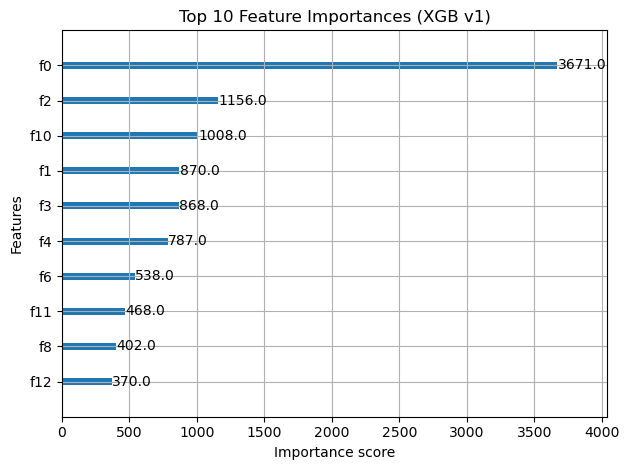

Train AUC: 0.9447 | Val AUC: 0.9456
Train AUC: 0.9451 | Val AUC: 0.9421
Train AUC: 0.9432 | Val AUC: 0.9425
Train AUC: 0.9438 | Val AUC: 0.9437
Train AUC: 0.9442 | Val AUC: 0.9439
✅ AUC (xgb_v2): 0.9435738352216289


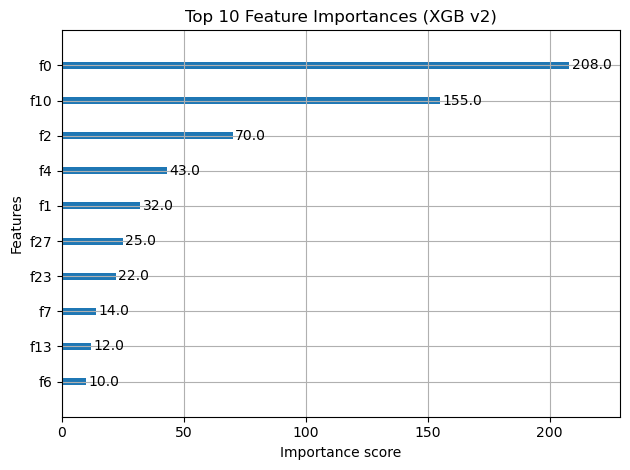

In [15]:
# Run the models
# run_rf_v1()
# run_rf_v2()
run_xgb_v1()
run_xgb_v2()